In [56]:
from tcn import TCN

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
import os, joblib
from tqdm import tqdm 
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Conv1D, GRU, Dense, Bidirectional, BatchNormalization, Input, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Model, Sequential, load_model
import seaborn as sns
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, roc_auc_score

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [81]:
dataset = pd.read_parquet(r"/kaggle/input/cicidscollection/cic-collection.parquet")
print(dataset.shape)
dataset.head()

(9167581, 59)


,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,ClassLabel
0,4,2,0,12.0,0.0,6.0,6.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign
1,1,2,0,12.0,0.0,6.0,6.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign
2,3,2,0,12.0,0.0,6.0,6.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign
3,1,2,0,12.0,0.0,6.0,6.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign
4,609,7,4,484.0,414.0,233.0,69.14286,111.967896,207.0,103.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign,Benign


In [4]:
dataset['Label'].value_counts()

Label
Benign                  7186189
DDoS-LOIC-HTTP           575364
DoS-Hulk                 318740
DDoS-HOIC                198861
Botnet                   145968
DDoS                     128062
DDoS-NTP                 121328
DDoS-TFTP                 98833
Bruteforce-SSH            97260
Infiltration              94857
DoS-Goldeneye             52324
DDoS-Syn                  47757
DDoS-UDP                  28863
DoS-Slowloris             15243
DDoS-MSSQL                11784
DDoS-UDPLag                8452
Bruteforce-FTP             5984
DoS-Slowhttptest           5271
DDoS-Ddossim               5115
DDoS-DNS                   3668
DoS-Slowread               2786
Portscan                   2255
DDoS-LDAP                  2092
Webattack-bruteforce       2020
DDoS-SNMP                  2017
DDoS-Slowloris             1858
DoS-Slowheaders            1649
Webattack-XSS               876
DoS-Rudy                    699
DDoS-NetBIOS                675
DoS-Slowbody                621
We

In [5]:
dataset['ClassLabel'].value_counts()

ClassLabel
Benign          7186189
DDoS            1234729
DoS              397344
Botnet           145968
Bruteforce       103244
Infiltration      94857
Webattack          2995
Portscan           2255
Name: count, dtype: int64

In [5]:
dataset.describe()

,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Mean,...,Fwd Act Data Packets,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,9.167581e+06,9.167581e+06,9.167581e+06,9.167581e+06,9.167581e+06,9.167581e+06,9.167581e+06,9.167581e+06,9.167581e+06,9.167581e+06,...,9.167581e+06,9.167581e+06,9.167581e+06,9.167581e+06,9.167581e+06,9.167581e+06,9.167581e+06,9.167581e+06,9.167581e+06,9.167581e+06
mean,1.590669e+07,4.079505e+01,9.505221e+00,2.063825e+03,1.001084e+04,2.946960e+02,8.127664e+01,1.043248e+02,6.070652e+02,2.002887e+02,...,3.634311e+01,-1.071509e+06,1.167681e+05,5.520761e+04,1.930339e+05,8.280822e+04,8.015305e+06,5.491758e+05,8.775097e+06,7.413580e+06
std,6.569715e+08,2.066283e+03,5.805652e+02,8.358580e+04,1.281297e+06,5.018536e+02,1.422410e+02,1.989876e+02,1.180525e+03,3.792937e+02,...,2.053093e+03,3.372568e+07,1.476691e+06,8.546709e+05,1.981935e+06,1.272038e+06,3.503701e+08,2.251440e+08,8.321556e+08,8.463088e+07
min,-9.190110e+11,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-1.408238e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.160100e+04,2.000000e+00,1.000000e+00,2.900000e+01,0.000000e+00,2.000000e+01,7.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.966860e+05,3.000000e+00,2.000000e+00,9.700000e+01,2.320000e+02,5.500000e+01,4.400000e+01,1.154701e+01,1.520000e+02,1.080000e+02,...,1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.562333e+06,7.000000e+00,5.000000e+00,9.350000e+02,9.640000e+02,5.070000e+02,1.076667e+02,1.807106e+02,9.640000e+02,2.163750e+02,...,4.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.200000e+08,3.096290e+05,2.919220e+05,1.443918e+08,6.554530e+08,6.444000e+04,1.652931e+04,1.840158e+04,6.516000e+04,3.387929e+04,...,3.096280e+05,6.724045e+07,1.140000e+08,7.495335e+07,1.140000e+08,1.140000e+08,3.955714e+11,2.622479e+11,9.797810e+11,2.399340e+11


In [23]:
def encode_dataset(dataset):
    dataset_encoded = dataset.copy()
    # encode categorical (string) values as numbers
    for column in tqdm(['ClassLabel', 'Label']):
        if dataset[column].dtype == 'object' or str(dataset[column].dtype) == 'category':
            dataset_encoded[column] = dataset[column].astype('category').cat.codes
        

    print(dataset_encoded.head())
    
    return dataset_encoded

dataset_encoded = encode_dataset(dataset)

100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

   Flow Duration  Total Fwd Packets  Total Backward Packets  \
0              4                  2                       0   
1              1                  2                       0   
2              3                  2                       0   
3              1                  2                       0   
4            609                  7                       4   

   Fwd Packets Length Total  Bwd Packets Length Total  Fwd Packet Length Max  \
0                      12.0                       0.0                    6.0   
1                      12.0                       0.0                    6.0   
2                      12.0                       0.0                    6.0   
3                      12.0                       0.0                    6.0   
4                     484.0                     414.0                  233.0   

   Fwd Packet Length Mean  Fwd Packet Length Std  Bwd Packet Length Max  \
0                 6.00000               0.000000                 

In [24]:
def generate_training_test_data(df, extra_trees_classifier):
     # dataset has 58 columns, 56 are the independent input variables excluding 'ClassLabel' & 'Label'
    X = df.drop(['ClassLabel', 'Label'], axis=1)
    print(f'Number of Features before feature selection {X.shape}')
    y = df['Label'].reset_index(drop=True) # set the y to the dependent output variable
    
    model = extra_trees_classifier()
    chunksize = 100000
    for i in tqdm(range(0, len(df), chunksize)):
        X_chunk = X.iloc[i:i+chunksize]
        y_chunk = y.iloc[i:i+chunksize]

        model.fit(X_chunk, y_chunk)  # Train model on the current chunk

    return X, y, model
    
X, y, model = generate_training_test_data(dataset_encoded, ExtraTreesClassifier)

Number of Features before feature selection (9167581, 57)


100%|██████████| 92/92 [04:49<00:00,  3.14s/it]


In [25]:
%matplotlib inline

def extra_tree_classifier(feature_count, model, X):

    feat_importances = pd.Series(model.feature_importances_, index = X.columns)
    correlations = feat_importances.nlargest(X.shape[1]+1)

    corr_df = pd.DataFrame(correlations).reset_index()
    corr_df.columns = ['features', 'data']
    
    # Select top features based on absolute correlation
    df_output = corr_df.nlargest(feature_count, "data")
    threshold = df_output['data'][len(df_output)-1]
    
    fig, ax = plt.subplots(1, figsize=(9.5,5.5))
    
    ax.bar(corr_df['features'], corr_df['data'], align="center")        
    ax.axhline(y=threshold, color='r', linestyle='dashed', linewidth=1, label=f'Threshold: {threshold}')  # Add line
    plt.title('Feature Correlation with Output - Label\n', loc='left', fontsize=22)
    plt.xlabel('Features')
    plt.yticks(fontsize=8)
    plt.xticks(rotation = 90, fontsize=8)
    plt.ylabel('Correlations')
    plt.tight_layout()
    plt.margins(x=0)
    plt.show()

    return df_output

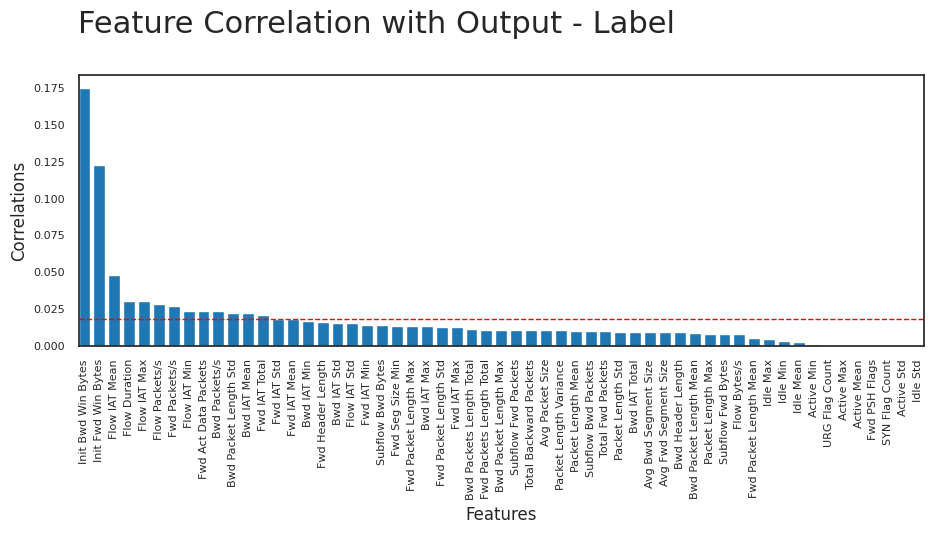

,features,data
0,Init Bwd Win Bytes,0.175214
1,Init Fwd Win Bytes,0.123116
2,Flow IAT Mean,0.047813
3,Flow Duration,0.030642
4,Flow IAT Max,0.030540
5,Flow Packets/s,0.028341
6,Fwd Packets/s,0.027159
7,Flow IAT Min,0.024005
8,Fwd Act Data Packets,0.023514
9,Bwd Packets/s,0.023486


In [28]:
ext_tree_selected_features = extra_tree_classifier(15, model, X)
ext_tree_selected_features

In [29]:
def correlation_with_target(X, y, method="pearson", feature_count=10):
    """
    Compute correlations between each feature in X and the target column y.
    
    Parameters:
        X (pd.DataFrame): DataFrame containing feature columns.
        y (pd.Series or array-like): Target column (categorical integer encoding).
        method (str): Correlation method - "pearson" or "spearman".
        threshold (float): Minimum correlation value to include in the plot.
    
    Returns:
        pd.DataFrame: DataFrame containing features and their correlation values.
    """
    # Ensure y is a pandas Series for compatibility
    if not isinstance(y, pd.Series):
        y = pd.Series(y, name="Label")
    
    # Compute correlations for each feature in X with y
    correlations = []
    for feature in tqdm(X.columns):
        if method == "pearson":
            corr, _ = stats.pearsonr(X[feature], y)
        elif method == "spearman":
            corr, _ = stats.spearmanr(X[feature], y)
        else:
            raise ValueError("Unsupported method. Choose 'pearson' or 'spearman'.")
        
        correlations.append((feature, abs(corr)))  # Use absolute correlation
    
    # Convert to DataFrame
    corr_df = pd.DataFrame(correlations, columns=["features", "data"])

    corr_df = corr_df.sort_values(by='data', ascending=False).reset_index(drop=True)

    threshold_feature_score = corr_df['data'][feature_count - 1]
    
    # Select top features based on absolute correlation
    top_features = corr_df.nlargest(feature_count, "data")
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(corr_df["features"], corr_df["data"], align="center")
    plt.title(f"Feature Correlation with Target ({method.capitalize()} Method)", fontsize=22)
    plt.axhline(y=threshold_feature_score, color='r', linestyle='dashed', linewidth=1, label=f'Threshold: {threshold_feature_score}')  # Add line
    plt.xlabel("Features", fontsize=12)
    plt.xticks(rotation=90, fontsize=10)
    plt.ylabel("Correlation",  fontsize=12)
    plt.tight_layout()
    plt.margins(x=0)
    plt.show()
    
    return top_features

100%|██████████| 57/57 [02:34<00:00,  2.72s/it]


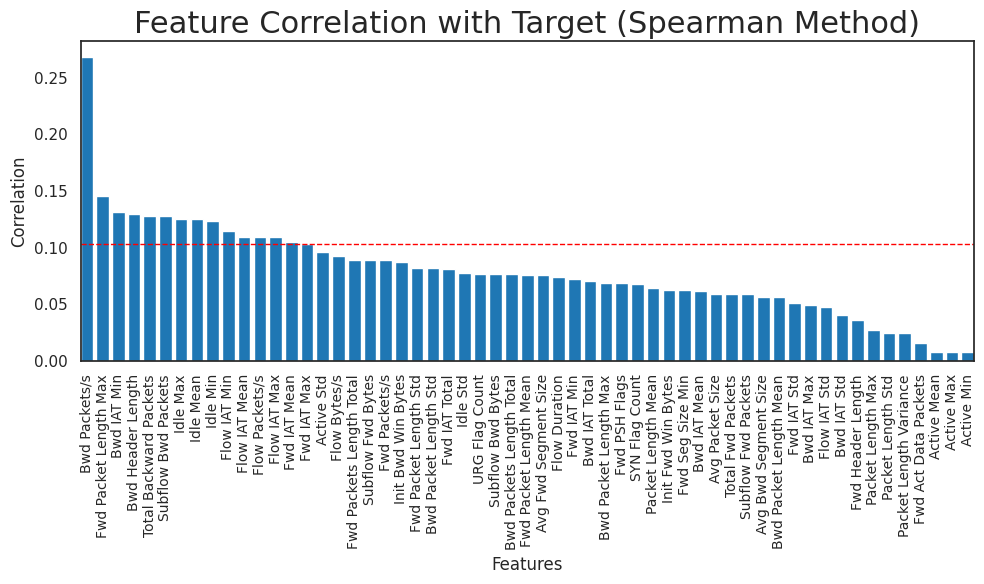

,features,data
0,Bwd Packets/s,0.268486
1,Fwd Packet Length Max,0.145693
2,Bwd IAT Min,0.131792
3,Bwd Header Length,0.130033
4,Total Backward Packets,0.128212
5,Subflow Bwd Packets,0.128212
6,Idle Max,0.125227
7,Idle Mean,0.124842
8,Idle Min,0.123894
9,Flow IAT Min,0.114765


In [30]:
spearman_selected_features = correlation_with_target(X, y, method="spearman", feature_count=15)
spearman_selected_features

100%|██████████| 57/57 [00:14<00:00,  3.89it/s]


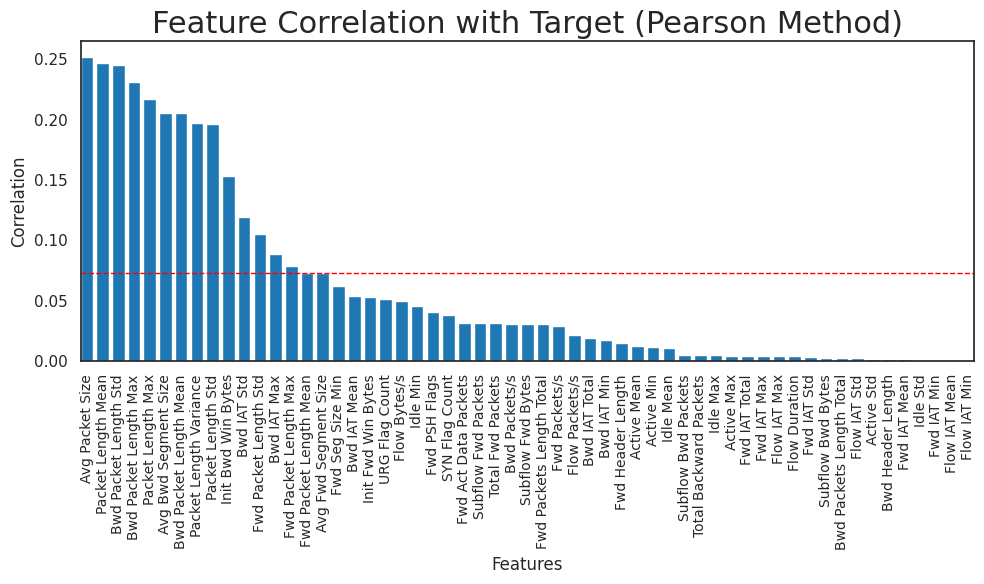

,features,data
0,Avg Packet Size,0.252134
1,Packet Length Mean,0.246747
2,Bwd Packet Length Std,0.244923
3,Bwd Packet Length Max,0.230939
4,Packet Length Max,0.216741
5,Avg Bwd Segment Size,0.205729
6,Bwd Packet Length Mean,0.205729
7,Packet Length Variance,0.197260
8,Packet Length Std,0.195905
9,Init Bwd Win Bytes,0.152962


In [31]:
pearson_selected_features = correlation_with_target(X, y, method="pearson", feature_count=15)
pearson_selected_features

In [32]:
def rank_features(selected_features_list):
    """
    Aggregate and rank features from multiple feature selection methods.

    Parameters:
        selected_features_list (list of pd.DataFrame): List of DataFrames containing "Features" and "Data" columns
        from different feature analysis methods.

    Returns:
        pd.DataFrame: DataFrame with features ranked by their cumulative average score across methods.
    """
    # Initialize an empty DataFrame to hold combined scores
    combined_df = pd.DataFrame()

    # Merge all selected_features DataFrames on "Features" column
    for i, df in enumerate(selected_features_list):
        # Rename the "Data" column to indicate the method (e.g., "Data_1", "Data_2", ...)
        df_renamed = df.rename(columns={"data": f"Data_{i+1}"})
        if combined_df.empty:
            combined_df = df_renamed
        else:
            combined_df = pd.merge(combined_df, df_renamed, on="features", how="outer")
    
    # Fill missing scores with 0
    combined_df.fillna(0, inplace=True)

    # Compute the average score across methods
    data_columns = [col for col in combined_df.columns if col.startswith("Data_")]
    combined_df["Average_Score"] = combined_df[data_columns].mean(axis=1)

    # Sort by the average score in descending order
    ranked_features = combined_df.sort_values(by="Average_Score", ascending=False).reset_index(drop=True)
    
    return ranked_features

In [33]:
ranked_features = rank_features([ext_tree_selected_features, pearson_selected_features, spearman_selected_features])
selected_features = ranked_features[:15] # Select the top 15 features based on their average ranking
ranked_features

,features,Data_1,Data_2,Data_3,Average_Score
0,Init Bwd Win Bytes,0.175214,0.152962,0.000000,0.109392
1,Bwd Packets/s,0.023486,0.000000,0.268486,0.097324
2,Bwd Packet Length Std,0.022594,0.244923,0.000000,0.089172
3,Avg Packet Size,0.000000,0.252134,0.000000,0.084045
4,Packet Length Mean,0.000000,0.246747,0.000000,0.082249
5,Bwd Packet Length Max,0.000000,0.230939,0.000000,0.076980
6,Fwd Packet Length Max,0.000000,0.078543,0.145693,0.074745
7,Packet Length Max,0.000000,0.216741,0.000000,0.072247
8,Avg Bwd Segment Size,0.000000,0.205729,0.000000,0.068576
9,Bwd Packet Length Mean,0.000000,0.205729,0.000000,0.068576


In [34]:
selected_features

,features,Data_1,Data_2,Data_3,Average_Score
0,Init Bwd Win Bytes,0.175214,0.152962,0.000000,0.109392
1,Bwd Packets/s,0.023486,0.000000,0.268486,0.097324
2,Bwd Packet Length Std,0.022594,0.244923,0.000000,0.089172
3,Avg Packet Size,0.000000,0.252134,0.000000,0.084045
4,Packet Length Mean,0.000000,0.246747,0.000000,0.082249
5,Bwd Packet Length Max,0.000000,0.230939,0.000000,0.076980
6,Fwd Packet Length Max,0.000000,0.078543,0.145693,0.074745
7,Packet Length Max,0.000000,0.216741,0.000000,0.072247
8,Avg Bwd Segment Size,0.000000,0.205729,0.000000,0.068576
9,Bwd Packet Length Mean,0.000000,0.205729,0.000000,0.068576


### Define Method to Save Dataset After Preprocessing

In [35]:
def save_dataset(dataset_encoded):
    # Assuming 'dataset' is your large object
    dataset_checkpoint_file = 'dataset_checkpoint.joblib'

    # Save preprocessed dataset to joblib
    joblib.dump(dataset_encoded, dataset_checkpoint_file)

In [36]:
X_selected = dataset_encoded[selected_features['features']]
dataset_to_save = X_selected.copy(deep=True)
dataset_to_save['Label'] = y
save_dataset(dataset_to_save)

### Load Saved Preprocessed Dataset

In [3]:
def load_dataset():
    # Load preprocessed dataset from joblib
    with open('dataset_checkpoint.joblib', 'rb') as f:
        loaded_dataset = joblib.load(f)
        return loaded_dataset

### Define Condition to Load Preprocessed Dataset from Memory or File

In [4]:
try:
    # Check if the variable exists and is not None
    if 'dataset_encoded' not in globals() or dataset_encoded is None:
        dataset_encoded = load_dataset()
        print("dataset_encoded is empty: \n", dataset_encoded.shape)
        X_selected = dataset_encoded.drop(['Label'], axis=1)
        y = dataset_encoded['Label']
        print(dataset_encoded.head())  # Display the first 5 rows of loaded_X
except NameError:
    # Handle undefined variable case
    dataset_encoded = load_dataset()
    print("dataset_encoded is empty: \n", dataset_encoded.shape)
    X_selected = dataset_encoded.drop(['Label'], axis=1)
    y = dataset_encoded['Label']
    print(dataset_encoded.head())  # Display the first 5 rows of loaded_X

dataset_encoded is empty: 
 (9167581, 16)
   Init Bwd Win Bytes  Bwd Packets/s  Bwd Packet Length Std  Avg Packet Size  \
0                  -1       0.000000               0.000000          9.00000   
1                  -1       0.000000               0.000000          9.00000   
2                  -1       0.000000               0.000000          9.00000   
3                  -1       0.000000               0.000000          9.00000   
4                2053    6568.144531             119.511505         81.63636   

   Packet Length Mean  Bwd Packet Length Max  Fwd Packet Length Max  \
0            6.000000                    0.0                    6.0   
1            6.000000                    0.0                    6.0   
2            6.000000                    0.0                    6.0   
3            6.000000                    0.0                    6.0   
4           74.833336                  207.0                  233.0   

   Packet Length Max  Avg Bwd Segment Size  Bwd Pa

In [20]:
del dataset_encoded

In [5]:
dataset_encoded.head()

,Init Bwd Win Bytes,Bwd Packets/s,Bwd Packet Length Std,Avg Packet Size,Packet Length Mean,Bwd Packet Length Max,Fwd Packet Length Max,Packet Length Max,Avg Bwd Segment Size,Bwd Packet Length Mean,Packet Length Variance,Packet Length Std,Flow IAT Mean,Flow IAT Max,Flow IAT Min,Label
0,-1,0.000000,0.000000,9.00000,6.000000,0.0,6.0,6.0,0.0,0.0,0.000000,0.000000,4.000000,4.0,4.0,0
1,-1,0.000000,0.000000,9.00000,6.000000,0.0,6.0,6.0,0.0,0.0,0.000000,0.000000,1.000000,1.0,1.0,0
2,-1,0.000000,0.000000,9.00000,6.000000,0.0,6.0,6.0,0.0,0.0,0.000000,0.000000,3.000000,3.0,3.0,0
3,-1,0.000000,0.000000,9.00000,6.000000,0.0,6.0,6.0,0.0,0.0,0.000000,0.000000,1.000000,1.0,1.0,0
4,2053,6568.144531,119.511505,81.63636,74.833336,207.0,233.0,233.0,103.5,103.5,11562.151367,107.527443,60.900002,381.0,2.0,0


### Scale features using standard scaler to prevent bias during training and test 

In [6]:
def scale_X(X):
    X_scaled = StandardScaler().fit_transform(X)
    return X_scaled
    
X_scaled = scale_X(X_selected)
print(X_scaled[:5])

[[-0.43090358 -0.09363997 -0.47810709 -0.65578968 -0.64938449 -0.51423338
  -0.5752593  -0.5756493  -0.52805745 -0.52805745 -0.20434228 -0.57441735
  -0.01543793 -0.01197977 -0.00276716]
 [-0.43090358 -0.09363997 -0.47810709 -0.65578968 -0.64938449 -0.51423338
  -0.5752593  -0.5756493  -0.52805745 -0.52805745 -0.20434228 -0.57441735
  -0.01543794 -0.01197977 -0.00276716]
 [-0.43090358 -0.09363997 -0.47810709 -0.65578968 -0.64938449 -0.51423338
  -0.5752593  -0.5756493  -0.52805745 -0.52805745 -0.20434228 -0.57441735
  -0.01543793 -0.01197977 -0.00276716]
 [-0.43090358 -0.09363997 -0.47810709 -0.65578968 -0.64938449 -0.51423338
  -0.5752593  -0.5756493  -0.52805745 -0.52805745 -0.20434228 -0.57441735
  -0.01543794 -0.01197977 -0.00276716]
 [-0.32521074  0.25977721 -0.24100176 -0.33966822 -0.32083141 -0.33888762
  -0.12293617 -0.389721   -0.2551818  -0.2551818  -0.19226505 -0.29405876
  -0.01543774 -0.01197934 -0.00276716]]


#### Split Dataset into Training and Validation dataset

In [7]:
from sklearn.model_selection import train_test_split

def split_train_test(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, stratify = y, random_state=10)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_train_test(X_scaled, y)
print(f'X_train Shape: {X_train.shape}') # shape of the training input variables i.e., row and columns
print(f'X_test Shape: {X_test.shape}') # shape of the test input variables i.e., row and columns
print(f'y_train Shape: {y_train.shape}') # shape of the training output variables i.e., row and columns
print(f'y_test Shape: {y_test.shape}') # shape of the test output variables i.e., row and columns

X_train Shape: (6417306, 15)
X_test Shape: (2750275, 15)
y_train Shape: (6417306,)
y_test Shape: (2750275,)


#### Define Method to Reshape output - y (Label) into 2D using One-hot Encoding

In [8]:
# This code changes the "is_attack" column from 1 to 8 which maps to the number of attacks to enable the NN model classify better
def reshape_y(output):
    onehot = pd.get_dummies(output)
    output = onehot.to_numpy()
    
    return output

#### Define Method to Reshape 2D input - features to 3D for Reccurent Models 

In [9]:
def reshape_x(data):
    if isinstance(data, pd.DataFrame):
        data = data.values
    
    # Reshape the data into a 3D array
    num_samples = data.shape[0] 
    input = np.zeros((num_samples, time_steps, num_features))
    for i in range(num_samples):
        if i+time_steps < num_samples:
            input[i, :, :] = data[i:i+time_steps, :]
            
    return input

#### Reshape Dataset and define Training Parameters

In [10]:
time_steps = 4
num_features = X_selected.shape[1]
EPOCHS = 200
print(f'Feature Count: {num_features}')
# num_classes = len(dataset['Label'].value_counts())
num_classes = len(dataset_encoded['Label'].value_counts())
print(f'Num Classes: {num_classes}')

# reshape the X_train, X_test to be 3d array & trim the y_test and y_train to fit the row count of X_train and X_test
reshaped_X_train = reshape_x(X_train)
reshaped_X_test = reshape_x(X_test)
reshaped_y_train = reshape_y(y_train)
reshaped_y_test = reshape_y(y_test)

print(f'reshaped_X_train Shape: {reshaped_X_train.shape}') # shape of the training input variables i.e., row and columns
print(f'reshaped_X_test Shape: {reshaped_X_test.shape}') # shape of the test input variables i.e., row and columns
print(f'reshaped_y_train Shape: {reshaped_y_train.shape}') # shape of the training output variables i.e., row and columns
print(f'reshaped_y_test Shape: {reshaped_y_test.shape}') # shape of the test output variables i.e., row and columns

Feature Count: 15
Num Classes: 33
reshaped_X_train Shape: (6417306, 4, 15)
reshaped_X_test Shape: (2750275, 4, 15)
reshaped_y_train Shape: (6417306, 33)
reshaped_y_test Shape: (2750275, 33)


#### Define TPU Strategy for training tensorflow Model with TPU

In [11]:
# Initialize TPU
try:
    print('Initiated')
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU: ", tpu.master())
except ValueError:
    print("TPU not found. Please ensure the runtime is set to 'TPU'.")
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU initialized successfully.")
else:
    tpu_strategy = tf.distribute.get_strategy()

print("REPLICAS: ", tpu_strategy.num_replicas_in_sync)
print("All devices: ", tf.config.list_logical_devices('TPU'))

Initiated
Running on TPU:  
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1734108259.548163      13 service.cc:145] XLA service 0x5ae83f18cbf0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734108259.548227      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1734108259.548232      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1734108259.548235      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1734108259.548237      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1734108259.548240      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1734108259.548243      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1734108259.548246      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1734108259.548250      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [12]:
class WrappedBatchNormalization(BatchNormalization):
    def get_config(self):
        config = super(WrappedBatchNormalization, self).get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [23]:
def Build_TCN(time_steps, num_features, num_classes):
    # Define Input
    inputs = Input(shape=(time_steps, num_features))
    
    # TCN Layers
    x = TCN(64, dilations=[1,2], dropout_rate=0.00048473169852149387, return_sequences=True)(inputs)
    x = WrappedBatchNormalization()(x)
    x = TCN(64, dilations=[1,2], dropout_rate=0.00048473169852149387)(x)
    x = WrappedBatchNormalization()(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)  # Output Layer

    # Compile the modelL
    encoder_optimizer = Adam(learning_rate=0.0001, clipnorm=1.0) # Use clipnorm or clipvalue to cap gradient magnitudes
    model = Model(inputs=inputs, outputs=outputs, name='TCN_IDS') 
    model.compile(loss='categorical_crossentropy', optimizer=encoder_optimizer, metrics=['accuracy'])
    model.summary(line_length=90, show_trainable=True)

    return model

In [24]:
with tpu_strategy.scope():
    tcn_model = Build_TCN(time_steps, num_features, num_classes)

    tcn_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'tcn_model_best_v2.weights.h5', monitor='val_loss', mode='min', verbose=1, 
    save_best_only=True, save_weights_only=True
    )

Model: "TCN_IDS"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape              ┃       Param # ┃ Train… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ input_layer_3 (InputLayer)        │ (None, 4, 15)             │             0 │   -    │
├───────────────────────────────────┼───────────────────────────┼───────────────┼────────┤
│ tcn_6 (TCN)                       │ (None, 4, 64)             │        41,024 │   Y    │
├───────────────────────────────────┼───────────────────────────┼───────────────┼────────┤
│ wrapped_batch_normalization_6     │ (None, 4, 64)             │           256 │   Y    │
│ (WrappedBatchNormalization)       │                           │               │        │
├───────────────────────────────────┼───────────────────────────┼───────────────┼────────┤
│ tcn_7 (TCN)                       │ (None, 64)                │        49,408 │   Y    │
├───────────────────────────────────┼───────────────────────────┼───────────────┼────────┤
│ wrapped_batch_normalization_7     │ (None, 64)                │           256 │   Y    │
│ (WrappedBatchNormalization)       │                           │               │        │
├───────────────────────────────────┼───────────────────────────┼───────────────┼────────┤
│ dense_4 (Dense)                   │ (None, 33)                │         2,145 │   Y    │
└───────────────────────────────────┴───────────────────────────┴───────────────┴────────┘

 Total params: 93,089 (363.63 KB)

 Trainable params: 92,833 (362.63 KB)

 Non-trainable params: 256 (1.00 KB)

In [25]:
with tpu_strategy.scope():
    tcn_history = tcn_model.fit(reshaped_X_train, reshaped_y_train, 
                                epochs = EPOCHS, 
                                validation_data=(reshaped_X_test, reshaped_y_test), 
                                shuffle=True, 
                                verbose=1,
                                callbacks=[tcn_model_checkpoint_callback],
                                batch_size=65536 * tpu_strategy.num_replicas_in_sync) 

Epoch 1/200


2024-12-13 16:51:44.198514: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1734108705.149060     826 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(7b2b97174ea11ab3:0:0), session_name()


 1/13 ━━━━━━━━━━━━━━━━━━━━ 4:16 21s/step - accuracy: 0.0099 - loss: 3.7925

I0000 00:00:1734108722.663241     826 tpu_compile_op_common.cc:245] Compilation of 7b2b97174ea11ab3:0:0 with session name  took 17.514137648s and succeeded
I0000 00:00:1734108722.718388     826 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(7b2b97174ea11ab3:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16514280865114579315", property.function_library_fingerprint = 17061358669151671822, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "65536,4,15,;65536,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734108722.718438     826 tpu_compilation_cache_interface.cc:541] After adding entry for

12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.0171 - loss: 3.7619

I0000 00:00:1734108723.731376     891 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(9a832f9c0bb009ad:0:0), session_name()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0175 - loss: 3.7585  

I0000 00:00:1734108740.777735     891 tpu_compile_op_common.cc:245] Compilation of 9a832f9c0bb009ad:0:0 with session name  took 17.046316715s and succeeded
I0000 00:00:1734108740.840356     891 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(9a832f9c0bb009ad:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16514280865114579315", property.function_library_fingerprint = 17061358669151671822, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "15732,4,15,;15732,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734108740.840413     891 tpu_compilation_cache_interface.cc:541] After adding entry for


Epoch 1: val_loss improved from inf to 4.48376, saving model to tcn_model_best_v2.weights.h5


I0000 00:00:1734108752.783172     908 tpu_compile_op_common.cc:245] Compilation of a91aa11075390247:0:0 with session name  took 3.370737381s and succeeded
I0000 00:00:1734108752.786820     908 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(a91aa11075390247:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_10056011789391171723", property.function_library_fingerprint = 11979198101792901560, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "16105,4,15,;16105,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734108752.786852     908 tpu_compilation_cache_interface.cc:541] After adding entry for 

13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.0179 - loss: 3.7557 - val_accuracy: 0.0015 - val_loss: 4.4838
Epoch 2/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.0524 - loss: 3.5435
Epoch 2: val_loss improved from 4.48376 to 4.14231, saving model to tcn_model_best_v2.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - accuracy: 0.0552 - loss: 3.5374 - val_accuracy: 0.0048 - val_loss: 4.1423
Epoch 3/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.1368 - loss: 3.3993
Epoch 3: val_loss improved from 4.14231 to 3.88959, saving model to tcn_model_best_v2.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - accuracy: 0.1396 - loss: 3.3927 - val_accuracy: 0.0106 - val_loss: 3.8896
Epoch 4/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2181 - loss: 3.2817
Epoch 4: val_loss improved from 3.88959 to 3.66898, saving model to tcn_model_best_v2.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 252ms/step - accuracy: 0.2202 - loss: 3.2746 - val_accuracy: 0.0328 - va

In [26]:
tcn_train_metric = tcn_model.evaluate(reshaped_X_train, reshaped_y_train, return_dict=True, batch_size=65536 * tpu_strategy.num_replicas_in_sync)
tcn_test_metric = tcn_model.evaluate(reshaped_X_test, reshaped_y_test, return_dict=True, batch_size=65536 * tpu_strategy.num_replicas_in_sync)
print(f'Accuracy during training: {round(tcn_train_metric["accuracy"]*100, 2)}% and loss: {round(tcn_train_metric["loss"], 4)}')
print(f'Accuracy during test: {round(tcn_test_metric["accuracy"]*100, 2)}% and loss: {round(tcn_test_metric["loss"], 4)}')

2024-12-13 17:06:50.081422: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.


12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.9272 - loss: 0.2765

I0000 00:00:1734109611.184671     877 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(1fdfe046b079ac39:0:0), session_name()


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 354ms/step - accuracy: 0.9272 - loss: 0.2765


I0000 00:00:1734109614.742237     877 tpu_compile_op_common.cc:245] Compilation of 1fdfe046b079ac39:0:0 with session name  took 3.557514334s and succeeded
I0000 00:00:1734109614.746821     877 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(1fdfe046b079ac39:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_10056011789391171723", property.function_library_fingerprint = 11979198101792901560, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "15732,4,15,;15732,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734109614.746848     877 tpu_compilation_cache_interface.cc:541] After adding entry for 

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9264 - loss: 0.2769
Accuracy during training: 92.7% and loss: 0.2768
Accuracy during test: 92.64% and loss: 0.2767


In [31]:
# from tensorflow.keras.models import load_model
with tpu_strategy.scope():
    loaded_tcn_model = Build_TCN(time_steps, num_features, num_classes)
    loaded_tcn_model.load_weights('/kaggle/working/tcn_model_best_v6.weights.h5')

Model: "TCN_IDS"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape              ┃       Param # ┃ Train… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ input_layer_6 (InputLayer)        │ (None, 4, 15)             │             0 │   -    │
├───────────────────────────────────┼───────────────────────────┼───────────────┼────────┤
│ tcn_12 (TCN)                      │ (None, 4, 64)             │        41,024 │   Y    │
├───────────────────────────────────┼───────────────────────────┼───────────────┼────────┤
│ wrapped_batch_normalization_12    │ (None, 4, 64)             │           256 │   Y    │
│ (WrappedBatchNormalization)       │                           │               │        │
├───────────────────────────────────┼───────────────────────────┼───────────────┼────────┤
│ tcn_13 (TCN)                      │ (None, 64)                │        49,408 │   Y    │
├───────────────────────────────────┼───────────────────────────┼───────────────┼────────┤
│ wrapped_batch_normalization_13    │ (None, 64)                │           256 │   Y    │
│ (WrappedBatchNormalization)       │                           │               │        │
├───────────────────────────────────┼───────────────────────────┼───────────────┼────────┤
│ dense_7 (Dense)                   │ (None, 33)                │         2,145 │   Y    │
└───────────────────────────────────┴───────────────────────────┴───────────────┴────────┘

 Total params: 93,089 (363.63 KB)

 Trainable params: 92,833 (362.63 KB)

 Non-trainable params: 256 (1.00 KB)

In [32]:
loaded_tcn_train_metric = loaded_tcn_model.evaluate(reshaped_X_train, reshaped_y_train, return_dict=True, batch_size=65536 * tpu_strategy.num_replicas_in_sync)
loaded_tcn_test_metric = loaded_tcn_model.evaluate(reshaped_X_test, reshaped_y_test, return_dict=True, batch_size=65536 * tpu_strategy.num_replicas_in_sync)
print(f'Accuracy during training: {round(loaded_tcn_train_metric["accuracy"]*100, 2)}% and loss: {round(loaded_tcn_train_metric["loss"], 4)}')
print(f'Accuracy during test: {round(loaded_tcn_test_metric["accuracy"]*100, 2)}% and loss: {round(loaded_tcn_test_metric["loss"], 4)}')

2024-12-13 17:09:55.836242: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
I0000 00:00:1734109796.271349     909 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(68d1f98f67bf046c:0:0), session_name()


 3/13 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.9397 - loss: 0.2365

I0000 00:00:1734109799.796715     909 tpu_compile_op_common.cc:245] Compilation of 68d1f98f67bf046c:0:0 with session name  took 3.525294855s and succeeded
I0000 00:00:1734109799.801092     909 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(68d1f98f67bf046c:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_13396299314834042369", property.function_library_fingerprint = 6732922690226082351, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "65536,4,15,;65536,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734109799.801124     909 tpu_compilation_cache_interface.cc:541] After adding entry for k

12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9394 - loss: 0.2388

I0000 00:00:1734109800.481113     860 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(1707a64e6627ed17:0:0), session_name()


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 350ms/step - accuracy: 0.9394 - loss: 0.2390


I0000 00:00:1734109804.021839     860 tpu_compile_op_common.cc:245] Compilation of 1707a64e6627ed17:0:0 with session name  took 3.540677355s and succeeded
I0000 00:00:1734109804.025936     860 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(1707a64e6627ed17:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_13396299314834042369", property.function_library_fingerprint = 6732922690226082351, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "15732,4,15,;15732,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734109804.025967     860 tpu_compilation_cache_interface.cc:541] After adding entry for k

5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9390 - loss: 0.2407

I0000 00:00:1734109808.154896     839 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(ca14c8f6e862ceca:0:0), session_name()


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 797ms/step - accuracy: 0.9391 - loss: 0.2404


I0000 00:00:1734109811.769377     839 tpu_compile_op_common.cc:245] Compilation of ca14c8f6e862ceca:0:0 with session name  took 3.614417104s and succeeded
I0000 00:00:1734109811.772771     839 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(ca14c8f6e862ceca:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_13396299314834042369", property.function_library_fingerprint = 6732922690226082351, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "16105,4,15,;16105,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734109811.772801     839 tpu_compilation_cache_interface.cc:541] After adding entry for k

Accuracy during training: 93.92% and loss: 0.2398
Accuracy during test: 93.93% and loss: 0.2399


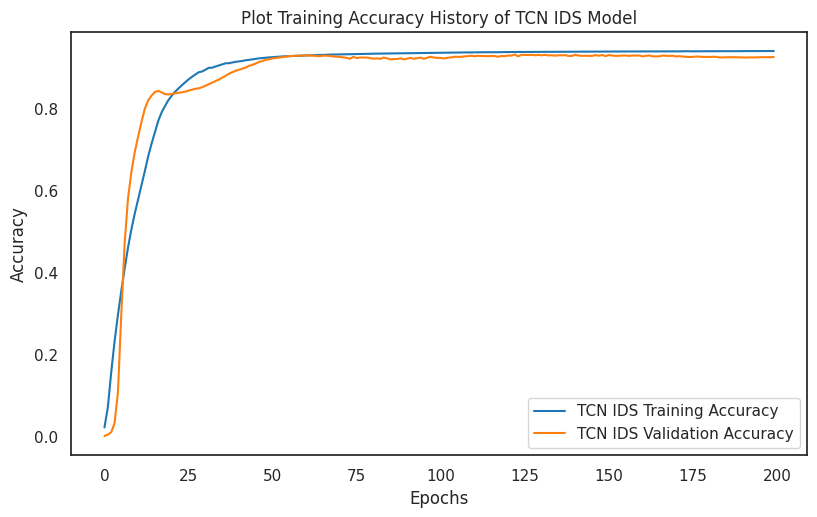

In [33]:
fig, ax = plt.subplots(1, figsize=(9.5,5.5))
plt.plot(range(EPOCHS), tcn_history.history['accuracy'], color=color_pal[0], label='TCN IDS Training Accuracy')
plt.plot(range(EPOCHS), tcn_history.history['val_accuracy'], color=color_pal[1], label='TCN IDS Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Plot Training Accuracy History of TCN IDS Model")
plt.legend()
plt.show()

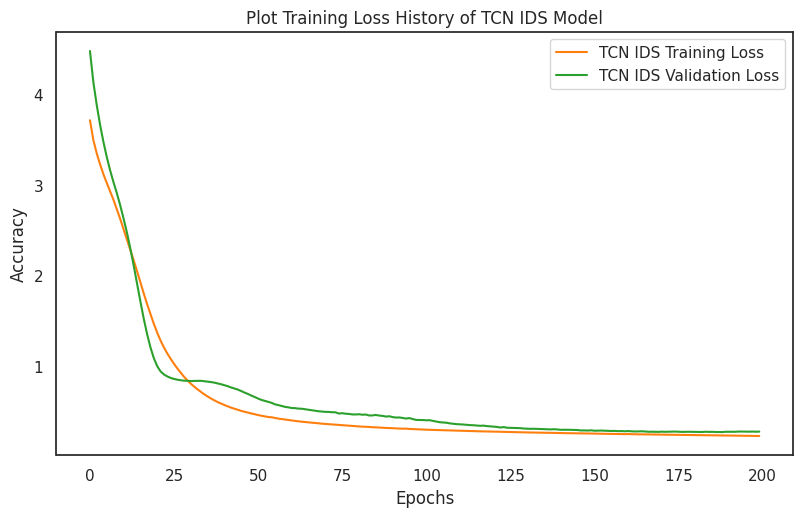

In [34]:
fig, ax = plt.subplots(1, figsize=(9.5,5.5))
plt.plot(range(EPOCHS), tcn_history.history['loss'], color=color_pal[1], label='TCN IDS Training Loss')
plt.plot(range(EPOCHS), tcn_history.history['val_loss'], color=color_pal[2], label='TCN IDS Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Plot Training Loss History of TCN IDS Model")
plt.legend()
plt.show()

In [37]:
def Build_CNN(time_steps, num_features, num_classes):
    # Define Input
    inputs = Input(shape=(time_steps, num_features))
    
    # TCN Layers
    x = Conv1D(64, 2, padding='causal')(inputs)
    x = BatchNormalization()(x)
    x = Conv1D(64, 2, padding='causal')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling1D(data_format='channels_last')(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)  # Output Layer

    # Compile the modelL
    encoder_optimizer = Adam(learning_rate=0.0001, clipnorm=1.0) # Use clipnorm or clipvalue to cap gradient magnitudes
    model = Model(inputs=inputs, outputs=outputs, name='CNN_IDS') 
    model.compile(loss='categorical_crossentropy', optimizer=encoder_optimizer, metrics=['accuracy'])
    model.summary(line_length=70, show_trainable=True)

    return model

In [38]:
with tpu_strategy.scope():
    cnn_model = Build_CNN(time_steps, num_features, num_classes)

    cnn_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'cnn_model_best_v2.weights.h5', monitor='val_loss', mode='min', verbose=1, 
    save_best_only=True, save_weights_only=True
    )

Model: "CNN_IDS"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━┓
┃ Layer (type)              ┃ Output Shape        ┃   Param # ┃ Tra… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━┩
│ input_layer_8             │ (None, 4, 15)       │         0 │  -   │
│ (InputLayer)              │                     │           │      │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ conv1d_2 (Conv1D)         │ (None, 4, 64)       │     1,984 │  Y   │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ batch_normalization_2     │ (None, 4, 64)       │       256 │  Y   │
│ (BatchNormalization)      │                     │           │      │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ conv1d_3 (Conv1D)         │ (None, 4, 64)       │     8,256 │  Y   │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ batch_normalization_3     │ (None, 4, 64)       │       256 │  Y   │
│ (BatchNormalization)      │                     │           │      │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ global_average_pooling1d… │ (None, 64)          │         0 │  -   │
│ (GlobalAveragePooling1D)  │                     │           │      │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ dense_9 (Dense)           │ (None, 33)          │     2,145 │  Y   │
└───────────────────────────┴─────────────────────┴───────────┴──────┘

 Total params: 12,897 (50.38 KB)

 Trainable params: 12,641 (49.38 KB)

 Non-trainable params: 256 (1.00 KB)

In [39]:
with tpu_strategy.scope():
    cnn_history = cnn_model.fit(reshaped_X_train, reshaped_y_train, 
                                epochs = EPOCHS, 
                                validation_data=(reshaped_X_test, reshaped_y_test), 
                                shuffle=True, 
                                verbose=1,
                                callbacks=[cnn_model_checkpoint_callback],
                                batch_size=65536 * tpu_strategy.num_replicas_in_sync) 

Epoch 1/200


2024-12-13 17:18:19.479819: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1734110300.194427     816 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(bfeb4ba267f17102:0:0), session_name()


 4/13 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.0131 - loss: 3.5641

I0000 00:00:1734110302.234917     816 tpu_compile_op_common.cc:245] Compilation of bfeb4ba267f17102:0:0 with session name  took 2.040416933s and succeeded
I0000 00:00:1734110302.241305     816 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(bfeb4ba267f17102:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_4125020934721554229", property.function_library_fingerprint = 8562935438039329926, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "65536,4,15,;65536,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734110302.241339     816 tpu_compilation_cache_interface.cc:541] After adding entry for ke

11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.0155 - loss: 3.5743

I0000 00:00:1734110302.850927     822 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(698e54967a7fd19a:0:0), session_name()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.0162 - loss: 3.5742

I0000 00:00:1734110304.676576     822 tpu_compile_op_common.cc:245] Compilation of 698e54967a7fd19a:0:0 with session name  took 1.825603506s and succeeded
I0000 00:00:1734110304.684180     822 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(698e54967a7fd19a:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_4125020934721554229", property.function_library_fingerprint = 8562935438039329926, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "15732,4,15,;15732,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734110304.684216     822 tpu_compilation_cache_interface.cc:541] After adding entry for ke


Epoch 1: val_loss improved from inf to 3.49319, saving model to cnn_model_best_v2.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 777ms/step - accuracy: 0.0165 - loss: 3.5741 - val_accuracy: 0.0525 - val_loss: 3.4932
Epoch 2/200


I0000 00:00:1734110311.478404     902 tpu_compile_op_common.cc:245] Compilation of 596c0fb5fca2f887:0:0 with session name  took 872.396675ms and succeeded
I0000 00:00:1734110311.481187     902 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(596c0fb5fca2f887:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_2478117495250619034", property.function_library_fingerprint = 10952046789269304398, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "16105,4,15,;16105,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734110311.481215     902 tpu_compilation_cache_interface.cc:541] After adding entry for k

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.0645 - loss: 3.5118
Epoch 2: val_loss improved from 3.49319 to 3.46089, saving model to cnn_model_best_v2.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - accuracy: 0.0661 - loss: 3.5115 - val_accuracy: 0.2293 - val_loss: 3.4609
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2064 - loss: 3.4601
Epoch 3: val_loss improved from 3.46089 to 3.43007, saving model to cnn_model_best_v2.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.2088 - loss: 3.4596 - val_accuracy: 0.3534 - val_loss: 3.4301
Epoch 4/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3334 - loss: 3.4174
Epoch 4: val_loss improved from 3.43007 to 3.40095, saving model to cnn_model_best_v2.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step - accuracy: 0.3379 - loss: 3.4161 - val_accuracy: 0.4358 - val_loss: 3.4009
Epoch 5/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4223 - loss: 3.3799
Epoch 5: val_loss improved

In [40]:
cnn_train_metric = cnn_model.evaluate(reshaped_X_train, reshaped_y_train, return_dict=True, batch_size=65536 * tpu_strategy.num_replicas_in_sync)
cnn_test_metric = cnn_model.evaluate(reshaped_X_test, reshaped_y_test, return_dict=True, batch_size=65536 * tpu_strategy.num_replicas_in_sync)
print(f'Accuracy during training: {round(cnn_train_metric["accuracy"]*100, 2)}% and loss: {round(cnn_train_metric["loss"], 4)}')
print(f'Accuracy during test: {round(cnn_test_metric["accuracy"]*100, 2)}% and loss: {round(cnn_test_metric["loss"], 4)}')

2024-12-13 17:38:31.267914: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.


12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7842 - loss: 0.8362

I0000 00:00:1734111512.283373     892 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(1c8af9cc6ae4ede1:0:0), session_name()


13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.7842 - loss: 0.8361


I0000 00:00:1734111513.299014     892 tpu_compile_op_common.cc:245] Compilation of 1c8af9cc6ae4ede1:0:0 with session name  took 1.015535932s and succeeded
I0000 00:00:1734111513.301916     892 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(1c8af9cc6ae4ede1:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_2478117495250619034", property.function_library_fingerprint = 10952046789269304398, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "15732,4,15,;15732,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734111513.301951     892 tpu_compilation_cache_interface.cc:541] After adding entry for k

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7844 - loss: 0.8335
Accuracy during training: 78.45% and loss: 0.8359
Accuracy during test: 78.46% and loss: 0.8328


In [41]:
with tpu_strategy.scope():
    loaded_cnn_model = Build_CNN(time_steps, num_features, num_classes)
    loaded_cnn_model.load_weights('/kaggle/working/cnn_model_best_v2.weights.h5')

Model: "CNN_IDS"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━┓
┃ Layer (type)              ┃ Output Shape        ┃   Param # ┃ Tra… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━┩
│ input_layer_9             │ (None, 4, 15)       │         0 │  -   │
│ (InputLayer)              │                     │           │      │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ conv1d_4 (Conv1D)         │ (None, 4, 64)       │     1,984 │  Y   │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ batch_normalization_4     │ (None, 4, 64)       │       256 │  Y   │
│ (BatchNormalization)      │                     │           │      │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ conv1d_5 (Conv1D)         │ (None, 4, 64)       │     8,256 │  Y   │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ batch_normalization_5     │ (None, 4, 64)       │       256 │  Y   │
│ (BatchNormalization)      │                     │           │      │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ global_average_pooling1d… │ (None, 64)          │         0 │  -   │
│ (GlobalAveragePooling1D)  │                     │           │      │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ dense_10 (Dense)          │ (None, 33)          │     2,145 │  Y   │
└───────────────────────────┴─────────────────────┴───────────┴──────┘

 Total params: 12,897 (50.38 KB)

 Trainable params: 12,641 (49.38 KB)

 Non-trainable params: 256 (1.00 KB)

/usr/local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [42]:
loaded_cnn_train_metric = cnn_model.evaluate(reshaped_X_train, reshaped_y_train, return_dict=True, batch_size=65536 * tpu_strategy.num_replicas_in_sync)
loaded_cnn_test_metric = cnn_model.evaluate(reshaped_X_test, reshaped_y_test, return_dict=True, batch_size=65536 * tpu_strategy.num_replicas_in_sync)
print(f'Accuracy during training: {round(loaded_cnn_train_metric["accuracy"]*100, 2)}% and loss: {round(loaded_cnn_train_metric["loss"], 4)}')
print(f'Accuracy during test: {round(loaded_cnn_test_metric["accuracy"]*100, 2)}% and loss: {round(loaded_cnn_test_metric["loss"], 4)}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7842 - loss: 0.8361
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7844 - loss: 0.8335
Accuracy during training: 78.45% and loss: 0.8359
Accuracy during test: 78.46% and loss: 0.8328


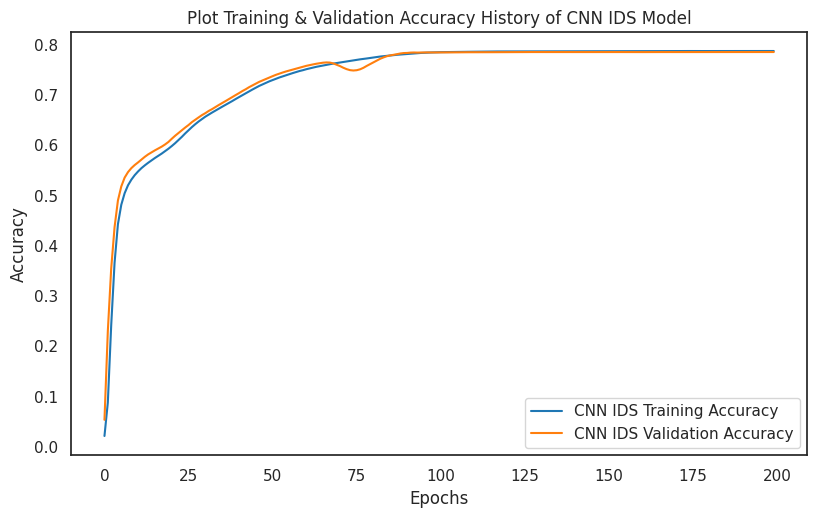

In [43]:
fig, ax = plt.subplots(1, figsize=(9.5,5.5))
plt.plot(range(EPOCHS), cnn_history.history['accuracy'], color=color_pal[0], label='CNN IDS Training Accuracy')
plt.plot(range(EPOCHS), cnn_history.history['val_accuracy'], color=color_pal[1], label='CNN IDS Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Plot Training & Validation Accuracy History of CNN IDS Model")
plt.legend()
plt.show()

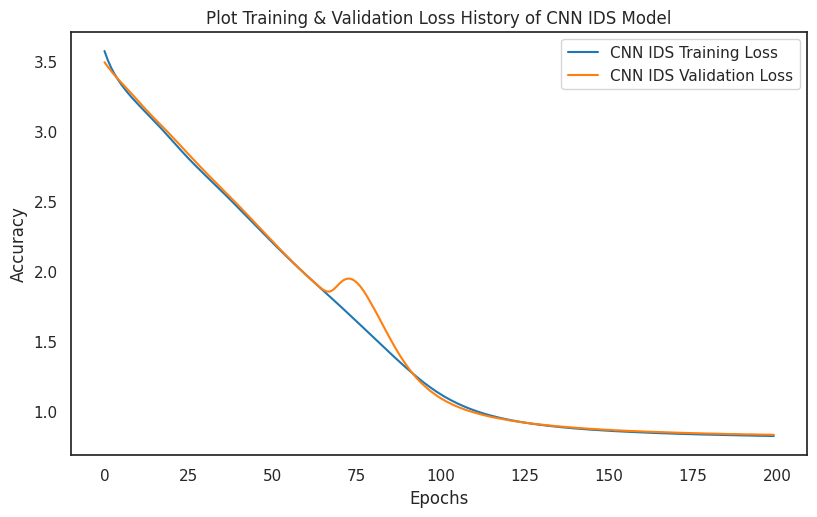

In [44]:
fig, ax = plt.subplots(1, figsize=(9.5,5.5))
plt.plot(range(EPOCHS), cnn_history.history['loss'], color=color_pal[0], label='CNN IDS Training Loss')
plt.plot(range(EPOCHS), cnn_history.history['val_loss'], color=color_pal[1], label='CNN IDS Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Plot Training & Validation Loss History of CNN IDS Model")
plt.legend()
plt.show()

In [45]:
def Build_LSTM(time_steps, num_features, num_classes):
    # Define Input
    inputs = Input(shape=(time_steps, num_features))
    
    # LSTM Layers
    x = LSTM(64, dropout=0.2, return_sequences=True)(inputs)
    x = BatchNormalization()(x)
    x = LSTM(64, dropout=0.2)(x)
    x = BatchNormalization()(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)  # Output Layer

    # Compile the modelL
    encoder_optimizer = Adam(learning_rate=0.0001, clipnorm=1.0) # Use clipnorm or clipvalue to cap gradient magnitudes
    model = Model(inputs=inputs, outputs=outputs, name='LSTM_IDS') 
    model.compile(loss='categorical_crossentropy', optimizer=encoder_optimizer, metrics=['accuracy'])
    model.summary(line_length=70, show_trainable=True)

    return model

In [46]:
with tpu_strategy.scope():
    lstm_model = Build_LSTM(time_steps, num_features, num_classes)

    lstm_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'lstm_model_best_v2.weights.h5', monitor='val_loss', mode='min', verbose=1, 
    save_best_only=True, save_weights_only=True
    )

Model: "LSTM_IDS"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━┓
┃ Layer (type)              ┃ Output Shape        ┃   Param # ┃ Tra… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━┩
│ input_layer_10            │ (None, 4, 15)       │         0 │  -   │
│ (InputLayer)              │                     │           │      │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ lstm (LSTM)               │ (None, 4, 64)       │    20,480 │  Y   │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ batch_normalization_6     │ (None, 4, 64)       │       256 │  Y   │
│ (BatchNormalization)      │                     │           │      │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ lstm_1 (LSTM)             │ (None, 64)          │    33,024 │  Y   │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ batch_normalization_7     │ (None, 64)          │       256 │  Y   │
│ (BatchNormalization)      │                     │           │      │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ dense_11 (Dense)          │ (None, 33)          │     2,145 │  Y   │
└───────────────────────────┴─────────────────────┴───────────┴──────┘

 Total params: 56,161 (219.38 KB)

 Trainable params: 55,905 (218.38 KB)

 Non-trainable params: 256 (1.00 KB)

In [47]:
with tpu_strategy.scope():
    lstm_history = lstm_model.fit(reshaped_X_train, reshaped_y_train, 
                                epochs = EPOCHS, 
                                validation_data=(reshaped_X_test, reshaped_y_test), 
                                shuffle=True, 
                                verbose=1,
                                callbacks=[lstm_model_checkpoint_callback],
                                batch_size=65536 * tpu_strategy.num_replicas_in_sync) 

Epoch 1/200


2024-12-13 17:45:57.281634: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1734111958.104669     885 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(fcfdb02737954ee9:0:0), session_name()


 1/13 ━━━━━━━━━━━━━━━━━━━━ 1:55 10s/step - accuracy: 0.0188 - loss: 4.1271

I0000 00:00:1734111964.489778     885 tpu_compile_op_common.cc:245] Compilation of fcfdb02737954ee9:0:0 with session name  took 6.38505405s and succeeded
I0000 00:00:1734111964.514234     885 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(fcfdb02737954ee9:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_8583299989090951837", property.function_library_fingerprint = 17341625654285574779, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "65536,4,15,;65536,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734111964.514271     885 tpu_compilation_cache_interface.cc:541] After adding entry for ke

12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.0197 - loss: 4.0914

I0000 00:00:1734111966.124426     870 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(6085aa561a508b0c:0:0), session_name()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.0197 - loss: 4.0888

I0000 00:00:1734111971.941589     870 tpu_compile_op_common.cc:245] Compilation of 6085aa561a508b0c:0:0 with session name  took 5.817108271s and succeeded
I0000 00:00:1734111971.967750     870 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(6085aa561a508b0c:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_8583299989090951837", property.function_library_fingerprint = 17341625654285574779, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "15732,4,15,;15732,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734111971.967784     870 tpu_compilation_cache_interface.cc:541] After adding entry for k


Epoch 1: val_loss improved from inf to 3.48275, saving model to lstm_model_best_v2.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.0197 - loss: 4.0866 - val_accuracy: 0.0558 - val_loss: 3.4828
Epoch 2/200


I0000 00:00:1734111979.645818     880 tpu_compile_op_common.cc:245] Compilation of f433172ee10014a3:0:0 with session name  took 915.988406ms and succeeded
I0000 00:00:1734111979.650925     880 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(f433172ee10014a3:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_718526403367737180", property.function_library_fingerprint = 11429730355728725888, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "16105,4,15,;16105,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734111979.650950     880 tpu_compilation_cache_interface.cc:541] After adding entry for ke

12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.0226 - loss: 3.9488
Epoch 2: val_loss improved from 3.48275 to 3.46939, saving model to lstm_model_best_v2.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step - accuracy: 0.0229 - loss: 3.9447 - val_accuracy: 0.2477 - val_loss: 3.4694
Epoch 3/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.0352 - loss: 3.8283
Epoch 3: val_loss improved from 3.46939 to 3.45436, saving model to lstm_model_best_v2.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - accuracy: 0.0360 - loss: 3.8248 - val_accuracy: 0.4589 - val_loss: 3.4544
Epoch 4/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.0667 - loss: 3.7256
Epoch 4: val_loss improved from 3.45436 to 3.43742, saving model to lstm_model_best_v2.weights.h5
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 291ms/step - accuracy: 0.0680 - loss: 3.7227 - val_accuracy: 0.5910 - val_loss: 3.4374
Epoch 5/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.1096 - loss: 3.6385
Epoch 5: val_loss i

In [48]:
lstm_train_metric = lstm_model.evaluate(reshaped_X_train, reshaped_y_train, return_dict=True, batch_size=65536 * tpu_strategy.num_replicas_in_sync)
lstm_test_metric = lstm_model.evaluate(reshaped_X_test, reshaped_y_test, return_dict=True, batch_size=65536 * tpu_strategy.num_replicas_in_sync)
print(f'Accuracy during training: {round(lstm_train_metric["accuracy"]*100, 2)}% and loss: {round(lstm_train_metric["loss"], 4)}')
print(f'Accuracy during test: {round(lstm_test_metric["accuracy"]*100, 2)}% and loss: {round(lstm_test_metric["loss"], 4)}')

2024-12-13 18:02:09.016733: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
I0000 00:00:1734112929.530381     824 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(f894ab17a5d56ad2:0:0), session_name()


 3/13 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9025 - loss: 0.3901

I0000 00:00:1734112931.173824     824 tpu_compile_op_common.cc:245] Compilation of f894ab17a5d56ad2:0:0 with session name  took 1.643392942s and succeeded
I0000 00:00:1734112931.178614     824 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(f894ab17a5d56ad2:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_2313854368553884408", property.function_library_fingerprint = 11173075715443721700, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "65536,4,15,;65536,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734112931.178648     824 tpu_compilation_cache_interface.cc:541] After adding entry for k

12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9021 - loss: 0.3919

I0000 00:00:1734112931.902310     819 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(48ba464cb75fc99a:0:0), session_name()


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9020 - loss: 0.3920


I0000 00:00:1734112932.787345     819 tpu_compile_op_common.cc:245] Compilation of 48ba464cb75fc99a:0:0 with session name  took 884.951543ms and succeeded
I0000 00:00:1734112932.792392     819 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(48ba464cb75fc99a:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_2313854368553884408", property.function_library_fingerprint = 11173075715443721700, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "15732,4,15,;15732,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734112932.792424     819 tpu_compilation_cache_interface.cc:541] After adding entry for k

5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9019 - loss: 0.3913

I0000 00:00:1734112936.839045     882 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(8e91bbdd9f50f0d9:0:0), session_name()


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.9018 - loss: 0.3914
Accuracy during training: 90.19% and loss: 0.3927
Accuracy during test: 90.16% and loss: 0.3917


I0000 00:00:1734112937.689794     882 tpu_compile_op_common.cc:245] Compilation of 8e91bbdd9f50f0d9:0:0 with session name  took 850.713754ms and succeeded
I0000 00:00:1734112937.695084     882 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(8e91bbdd9f50f0d9:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_2313854368553884408", property.function_library_fingerprint = 11173075715443721700, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "16105,4,15,;16105,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734112937.695123     882 tpu_compilation_cache_interface.cc:541] After adding entry for k

In [49]:
with tpu_strategy.scope():
    loaded_lstm_model = Build_LSTM(time_steps, num_features, num_classes)
    loaded_lstm_model.load_weights('/kaggle/working/lstm_model_best_v2.weights.h5')

Model: "LSTM_IDS"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━┓
┃ Layer (type)              ┃ Output Shape        ┃   Param # ┃ Tra… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━┩
│ input_layer_11            │ (None, 4, 15)       │         0 │  -   │
│ (InputLayer)              │                     │           │      │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ lstm_2 (LSTM)             │ (None, 4, 64)       │    20,480 │  Y   │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ batch_normalization_8     │ (None, 4, 64)       │       256 │  Y   │
│ (BatchNormalization)      │                     │           │      │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ lstm_3 (LSTM)             │ (None, 64)          │    33,024 │  Y   │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ batch_normalization_9     │ (None, 64)          │       256 │  Y   │
│ (BatchNormalization)      │                     │           │      │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ dense_12 (Dense)          │ (None, 33)          │     2,145 │  Y   │
└───────────────────────────┴─────────────────────┴───────────┴──────┘

 Total params: 56,161 (219.38 KB)

 Trainable params: 55,905 (218.38 KB)

 Non-trainable params: 256 (1.00 KB)

/usr/local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [50]:
loaded_lstm_train_metric = loaded_lstm_model.evaluate(reshaped_X_train, reshaped_y_train, return_dict=True, batch_size=65536 * tpu_strategy.num_replicas_in_sync)
loaded_lstm_test_metric = loaded_lstm_model.evaluate(reshaped_X_test, reshaped_y_test, return_dict=True, batch_size=65536 * tpu_strategy.num_replicas_in_sync)
print(f'Accuracy during training: {round(loaded_lstm_train_metric["accuracy"]*100, 2)}% and loss: {round(loaded_lstm_train_metric["loss"], 4)}')
print(f'Accuracy during test: {round(loaded_lstm_test_metric["accuracy"]*100, 2)}% and loss: {round(loaded_lstm_test_metric["loss"], 4)}')

I0000 00:00:1734112946.448918     906 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(cc8e2e3e02f712df:0:0), session_name()


 3/13 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9025 - loss: 0.3901

I0000 00:00:1734112948.133915     906 tpu_compile_op_common.cc:245] Compilation of cc8e2e3e02f712df:0:0 with session name  took 1.684929856s and succeeded
I0000 00:00:1734112948.138611     906 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(cc8e2e3e02f712df:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_406100277133580436", property.function_library_fingerprint = 8851156683655937844, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "65536,4,15,;65536,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734112948.138642     906 tpu_compilation_cache_interface.cc:541] After adding entry for key

12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9021 - loss: 0.3919

I0000 00:00:1734112948.853927     884 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(f1be3667256b1159:0:0), session_name()


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.9020 - loss: 0.3920


I0000 00:00:1734112949.660140     884 tpu_compile_op_common.cc:245] Compilation of f1be3667256b1159:0:0 with session name  took 806.116243ms and succeeded
I0000 00:00:1734112949.665136     884 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(f1be3667256b1159:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_406100277133580436", property.function_library_fingerprint = 8851156683655937844, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "15732,4,15,;15732,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734112949.665171     884 tpu_compilation_cache_interface.cc:541] After adding entry for key

5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.9019 - loss: 0.3913

I0000 00:00:1734112953.742626     857 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(8a73e030bf37fff2:0:0), session_name()


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.9018 - loss: 0.3914
Accuracy during training: 90.19% and loss: 0.3927
Accuracy during test: 90.16% and loss: 0.3917


I0000 00:00:1734112954.534601     857 tpu_compile_op_common.cc:245] Compilation of 8a73e030bf37fff2:0:0 with session name  took 791.883197ms and succeeded
I0000 00:00:1734112954.538413     857 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(8a73e030bf37fff2:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_406100277133580436", property.function_library_fingerprint = 8851156683655937844, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "16105,4,15,;16105,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734112954.538444     857 tpu_compilation_cache_interface.cc:541] After adding entry for key

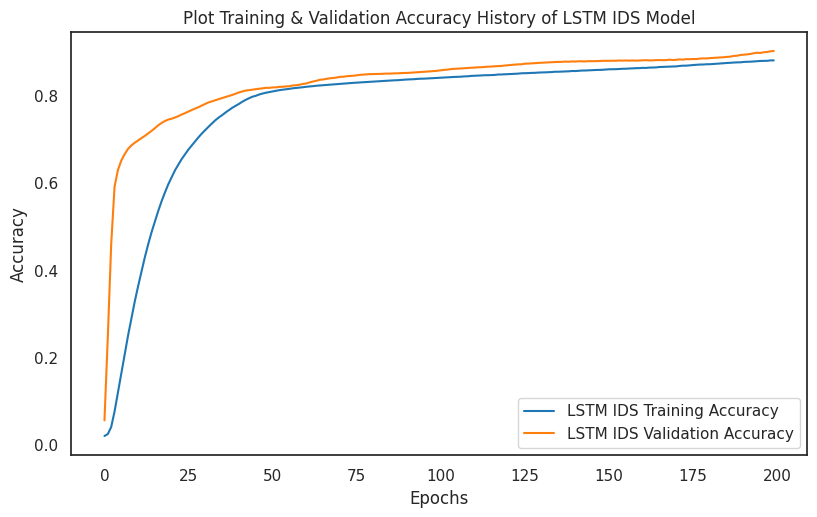

In [51]:
fig, ax = plt.subplots(1, figsize=(9.5,5.5))
plt.plot(range(EPOCHS), lstm_history.history['accuracy'], color=color_pal[0], label='LSTM IDS Training Accuracy')
plt.plot(range(EPOCHS), lstm_history.history['val_accuracy'], color=color_pal[1], label='LSTM IDS Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Plot Training & Validation Accuracy History of LSTM IDS Model")
plt.legend()
plt.show()

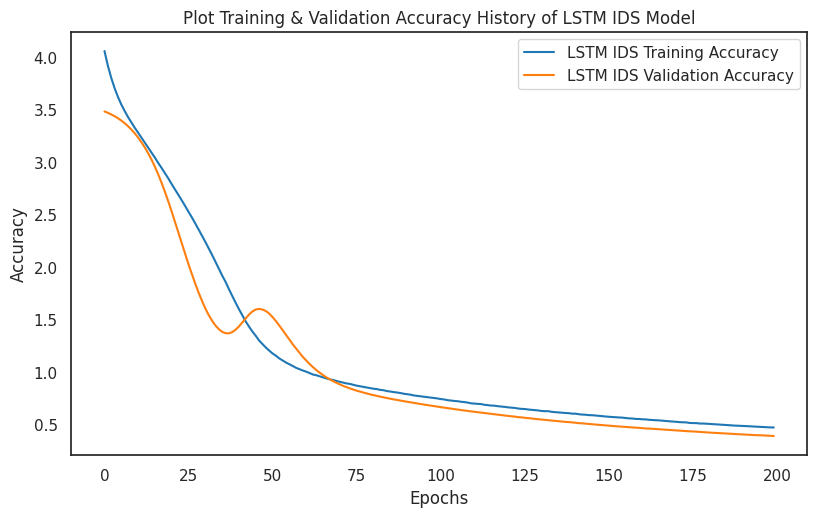

In [52]:
fig, ax = plt.subplots(1, figsize=(9.5,5.5))
plt.plot(range(EPOCHS), lstm_history.history['loss'], color=color_pal[0], label='LSTM IDS Training Accuracy')
plt.plot(range(EPOCHS), lstm_history.history['val_loss'], color=color_pal[1], label='LSTM IDS Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Plot Training & Validation Accuracy History of LSTM IDS Model")
plt.legend()
plt.show()

### Define Bidirectional LSTM IDS Model Specifications

In [56]:
class CustomBidirectional(Bidirectional):
    def get_config(self):
        config = super(CustomBidirectional, self).get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [53]:
def Build_BiLSTM(time_steps, num_features, num_classes):
    # Define Input
    inputs = Input(shape=(time_steps, num_features))
    
    # BiLSTM Layers
    x = Bidirectional(LSTM(64, dropout=0.2, return_sequences=True))(inputs)
    x = BatchNormalization()(x)
    x = Bidirectional(LSTM(64, dropout=0.2))(x)
    x = BatchNormalization()(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)  # Output Layer

    # Compile the modelL
    encoder_optimizer = Adam(learning_rate=0.0001, clipnorm=1.0) # Use clipnorm or clipvalue to cap gradient magnitudes
    model = Model(inputs=inputs, outputs=outputs, name='BiLSTM_IDS') 
    model.compile(loss='categorical_crossentropy', optimizer=encoder_optimizer, metrics=['accuracy'])
    # model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary(line_length=70, show_trainable=True)

    return model

### Build Bidirectional LSTM IDS Model

In [54]:
with tpu_strategy.scope():
    bilstm_model = Build_LSTM(time_steps, num_features, num_classes)

    bilstm_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'bilstm_model_best_v2.keras', monitor='val_loss', mode='min', verbose=1, 
    save_best_only=True
    )

Model: "LSTM_IDS"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━┓
┃ Layer (type)              ┃ Output Shape        ┃   Param # ┃ Tra… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━┩
│ input_layer_12            │ (None, 4, 15)       │         0 │  -   │
│ (InputLayer)              │                     │           │      │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ lstm_4 (LSTM)             │ (None, 4, 64)       │    20,480 │  Y   │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ batch_normalization_10    │ (None, 4, 64)       │       256 │  Y   │
│ (BatchNormalization)      │                     │           │      │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ lstm_5 (LSTM)             │ (None, 64)          │    33,024 │  Y   │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ batch_normalization_11    │ (None, 64)          │       256 │  Y   │
│ (BatchNormalization)      │                     │           │      │
├───────────────────────────┼─────────────────────┼───────────┼──────┤
│ dense_13 (Dense)          │ (None, 33)          │     2,145 │  Y   │
└───────────────────────────┴─────────────────────┴───────────┴──────┘

 Total params: 56,161 (219.38 KB)

 Trainable params: 55,905 (218.38 KB)

 Non-trainable params: 256 (1.00 KB)

### Train Bidirectional LSTM IDS Model

In [55]:
with tpu_strategy.scope():
    bilstm_history = bilstm_model.fit(reshaped_X_train, reshaped_y_train, 
                                epochs = EPOCHS, 
                                validation_data=(reshaped_X_test, reshaped_y_test), 
                                shuffle=True, 
                                verbose=1,
                                callbacks=[bilstm_model_checkpoint_callback],
                                batch_size=65536 * tpu_strategy.num_replicas_in_sync) 

Epoch 1/200


2024-12-13 18:04:22.303758: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1734113063.186663     874 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(f5aa7c81e44b45c4:0:0), session_name()


 1/13 ━━━━━━━━━━━━━━━━━━━━ 1:56 10s/step - accuracy: 0.0282 - loss: 4.1279

I0000 00:00:1734113069.613992     874 tpu_compile_op_common.cc:245] Compilation of f5aa7c81e44b45c4:0:0 with session name  took 6.427275952s and succeeded
I0000 00:00:1734113069.639307     874 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(f5aa7c81e44b45c4:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_1821298105508325533", property.function_library_fingerprint = 4939561824634156266, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "65536,4,15,;65536,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734113069.639344     874 tpu_compilation_cache_interface.cc:541] After adding entry for ke

12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.0306 - loss: 4.0941

I0000 00:00:1734113071.215269     854 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(2bdd228ed11da79:0:0), session_name()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.0308 - loss: 4.0914

I0000 00:00:1734113077.197225     854 tpu_compile_op_common.cc:245] Compilation of 2bdd228ed11da79:0:0 with session name  took 5.981902024s and succeeded
I0000 00:00:1734113077.225867     854 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(2bdd228ed11da79:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_1821298105508325533", property.function_library_fingerprint = 4939561824634156266, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "15732,4,15,;15732,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734113077.225926     854 tpu_compilation_cache_interface.cc:541] After adding entry for key 


Epoch 1: val_loss improved from inf to 3.46412, saving model to bilstm_model_best_v2.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.0310 - loss: 4.0891 - val_accuracy: 0.2783 - val_loss: 3.4641
Epoch 2/200


I0000 00:00:1734113084.737774     885 tpu_compile_op_common.cc:245] Compilation of 9d9f6f274ccdbf4e:0:0 with session name  took 813.365519ms and succeeded
I0000 00:00:1734113084.743446     885 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(9d9f6f274ccdbf4e:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_13084171835872920110", property.function_library_fingerprint = 2422309333209160307, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "16105,4,15,;16105,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734113084.743486     885 tpu_compilation_cache_interface.cc:541] After adding entry for k

12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.0462 - loss: 3.9423
Epoch 2: val_loss improved from 3.46412 to 3.44242, saving model to bilstm_model_best_v2.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 286ms/step - accuracy: 0.0471 - loss: 3.9379 - val_accuracy: 0.5201 - val_loss: 3.4424
Epoch 3/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.0803 - loss: 3.8123
Epoch 3: val_loss improved from 3.44242 to 3.42152, saving model to bilstm_model_best_v2.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.0818 - loss: 3.8085 - val_accuracy: 0.6389 - val_loss: 3.4215
Epoch 4/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.1308 - loss: 3.7026
Epoch 4: val_loss improved from 3.42152 to 3.40075, saving model to bilstm_model_best_v2.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 301ms/step - accuracy: 0.1325 - loss: 3.6995 - val_accuracy: 0.6563 - val_loss: 3.4007
Epoch 5/200
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.1835 - loss: 3.6095
Epoch 5: val_loss improved f

### Evaluate Bidirectional LSTM IDS Model

In [57]:
bilstm_train_metric = bilstm_model.evaluate(reshaped_X_train, reshaped_y_train, return_dict=True, batch_size=65536 * tpu_strategy.num_replicas_in_sync)
bilstm_test_metric = bilstm_model.evaluate(reshaped_X_test, reshaped_y_test, return_dict=True, batch_size=65536 * tpu_strategy.num_replicas_in_sync)
print(f'Accuracy during training: {round(bilstm_train_metric["accuracy"]*100, 2)}% and loss: {round(bilstm_train_metric["loss"], 4)}')
print(f'Accuracy during test: {round(bilstm_test_metric["accuracy"]*100, 2)}% and loss: {round(bilstm_test_metric["loss"], 4)}')

2024-12-13 18:23:27.010084: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Add/ReadVariableOp.
I0000 00:00:1734114207.602894     831 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(1f21646453a95d32:0:0), session_name()


 3/13 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8895 - loss: 0.4118

I0000 00:00:1734114209.292775     831 tpu_compile_op_common.cc:245] Compilation of 1f21646453a95d32:0:0 with session name  took 1.689835959s and succeeded
I0000 00:00:1734114209.297612     831 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(1f21646453a95d32:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_13856203348333938143", property.function_library_fingerprint = 2669299646603012755, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "65536,4,15,;65536,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734114209.297640     831 tpu_compilation_cache_interface.cc:541] After adding entry for k

12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8898 - loss: 0.4130

I0000 00:00:1734114210.007976     847 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(3283293b5eb2ef8d:0:0), session_name()


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.8898 - loss: 0.4130


I0000 00:00:1734114210.838142     847 tpu_compile_op_common.cc:245] Compilation of 3283293b5eb2ef8d:0:0 with session name  took 830.123317ms and succeeded
I0000 00:00:1734114210.842613     847 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(3283293b5eb2ef8d:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_13856203348333938143", property.function_library_fingerprint = 2669299646603012755, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "15732,4,15,;15732,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734114210.842645     847 tpu_compilation_cache_interface.cc:541] After adding entry for k

5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8903 - loss: 0.4121

I0000 00:00:1734114214.988168     817 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(e4ceaab3bd24be18:0:0), session_name()


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.8903 - loss: 0.4123
Accuracy during training: 89.0% and loss: 0.4132
Accuracy during test: 89.0% and loss: 0.4128


I0000 00:00:1734114215.864699     817 tpu_compile_op_common.cc:245] Compilation of e4ceaab3bd24be18:0:0 with session name  took 876.477336ms and succeeded
I0000 00:00:1734114215.869424     817 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(e4ceaab3bd24be18:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_13856203348333938143", property.function_library_fingerprint = 2669299646603012755, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "16105,4,15,;16105,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734114215.869465     817 tpu_compilation_cache_interface.cc:541] After adding entry for k

### Load Optimal Bidirectional LSTM IDS Model from Training

In [58]:
with tpu_strategy.scope():
    loaded_bilstm_model = load_model('/kaggle/working/bilstm_model_best_v2.keras')
    loaded_bilstm_model.summary()

Model: "LSTM_IDS"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 4, 15)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 4, 64)          │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 4, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 33)             │         2,145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,973 (656.15 KB)

 Trainable params: 55,905 (218.38 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 111,812 (436.77 KB)

In [59]:
loaded_bilstm_train_metric = loaded_bilstm_model.evaluate(reshaped_X_train, reshaped_y_train, return_dict=True, batch_size=65536 * tpu_strategy.num_replicas_in_sync)
loaded_bilstm_test_metric = loaded_bilstm_model.evaluate(reshaped_X_test, reshaped_y_test, return_dict=True, batch_size=65536 * tpu_strategy.num_replicas_in_sync)
print(f'Accuracy during training: {round(loaded_bilstm_train_metric["accuracy"]*100, 2)}% and loss: {round(loaded_bilstm_train_metric["loss"], 4)}')
print(f'Accuracy during test: {round(loaded_bilstm_test_metric["accuracy"]*100, 2)}% and loss: {round(loaded_bilstm_test_metric["loss"], 4)}')

I0000 00:00:1734114237.488719     870 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(6e91d8c06a6e76a1:0:0), session_name()


 3/13 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8895 - loss: 0.4118

I0000 00:00:1734114239.209610     870 tpu_compile_op_common.cc:245] Compilation of 6e91d8c06a6e76a1:0:0 with session name  took 1.720851333s and succeeded
I0000 00:00:1734114239.214257     870 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(6e91d8c06a6e76a1:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16998348749086374317", property.function_library_fingerprint = 18072808080481741297, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "65536,4,15,;65536,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734114239.214287     870 tpu_compilation_cache_interface.cc:541] After adding entry for 

12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.8898 - loss: 0.4130

I0000 00:00:1734114239.940624     867 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(7d1b4aa2c108f38c:0:0), session_name()


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.8898 - loss: 0.4130


I0000 00:00:1734114240.829795     867 tpu_compile_op_common.cc:245] Compilation of 7d1b4aa2c108f38c:0:0 with session name  took 889.115953ms and succeeded
I0000 00:00:1734114240.833586     867 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(7d1b4aa2c108f38c:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16998348749086374317", property.function_library_fingerprint = 18072808080481741297, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "15732,4,15,;15732,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734114240.833611     867 tpu_compilation_cache_interface.cc:541] After adding entry for 

5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8903 - loss: 0.4121

I0000 00:00:1734114244.801965     848 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(32ac5d0130cf0714:0:0), session_name()


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.8903 - loss: 0.4123
Accuracy during training: 89.0% and loss: 0.4132
Accuracy during test: 89.0% and loss: 0.4128


I0000 00:00:1734114245.649790     848 tpu_compile_op_common.cc:245] Compilation of 32ac5d0130cf0714:0:0 with session name  took 847.771352ms and succeeded
I0000 00:00:1734114245.654280     848 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(32ac5d0130cf0714:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_16998348749086374317", property.function_library_fingerprint = 18072808080481741297, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "16105,4,15,;16105,33,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1734114245.654311     848 tpu_compilation_cache_interface.cc:541] After adding entry for 

In [82]:
with tpu_strategy.scope():
    loaded_bilstm_model = load_model('/kaggle/working/bilstm_model_best_v1.keras')
    loaded_bilstm_model.summary()

Model: "LSTM_IDS"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 4, 15)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 4, 64)          │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 4, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_35 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 33)             │         2,145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,973 (656.15 KB)

 Trainable params: 55,905 (218.38 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 111,812 (436.77 KB)

### Evaluate Loaded Bidirectional LSTM IDS Model

In [87]:
loaded_bilstm_train_metric = loaded_bilstm_model.evaluate(reshaped_X_train, reshaped_y_train, return_dict=True, batch_size=65536 * tpu_strategy.num_replicas_in_sync)
loaded_bilstm_test_metric = loaded_bilstm_model.evaluate(reshaped_X_test, reshaped_y_test, return_dict=True, batch_size=65536 * tpu_strategy.num_replicas_in_sync)
print(f'Accuracy during training: {round(loaded_bilstm_train_metric["accuracy"]*100, 2)}% and loss: {round(loaded_bilstm_train_metric["loss"], 4)}')
print(f'Accuracy during test: {round(loaded_bilstm_test_metric["accuracy"]*100, 2)}% and loss: {round(loaded_bilstm_test_metric["loss"], 4)}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8760 - loss: 0.4295
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8763 - loss: 0.4289
Accuracy during training: 87.61% and loss: 0.43
Accuracy during test: 87.63% and loss: 0.4294


### Visualise Training & Validation Accuracy History

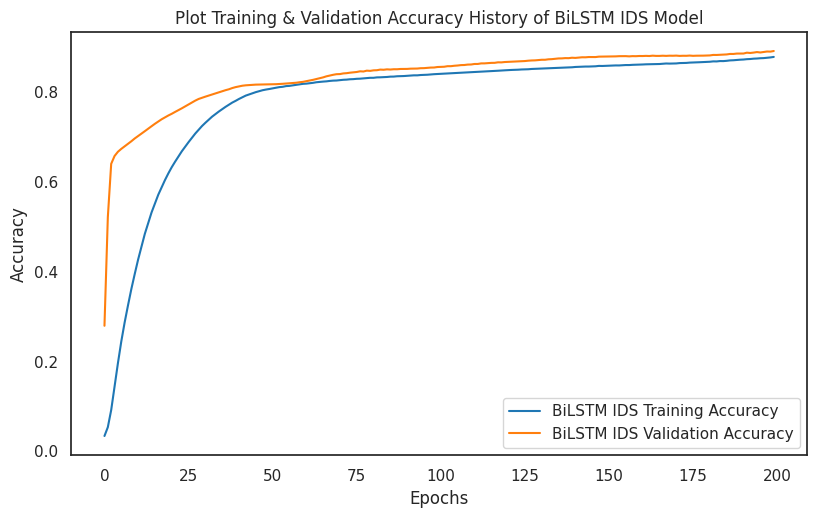

In [60]:
fig, ax = plt.subplots(1, figsize=(9.5,5.5))
plt.plot(range(EPOCHS), bilstm_history.history['accuracy'], color=color_pal[0], label='BiLSTM IDS Training Accuracy')
plt.plot(range(EPOCHS), bilstm_history.history['val_accuracy'], color=color_pal[1], label='BiLSTM IDS Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Plot Training & Validation Accuracy History of BiLSTM IDS Model")
plt.legend()
plt.show()

### Visualise Training & Validation Loss History

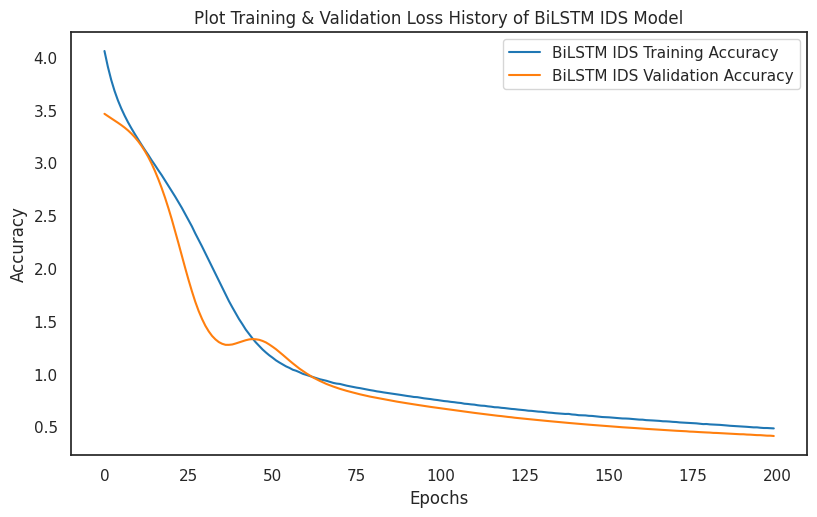

In [61]:
fig, ax = plt.subplots(1, figsize=(9.5,5.5))
plt.plot(range(EPOCHS), bilstm_history.history['loss'], color=color_pal[0], label='BiLSTM IDS Training Accuracy')
plt.plot(range(EPOCHS), bilstm_history.history['val_loss'], color=color_pal[1], label='BiLSTM IDS Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Plot Training & Validation Loss History of BiLSTM IDS Model")
plt.legend()
plt.show()

In [62]:
def r(number):
    return round(number * 100, 2)

## Compare IDS Model Performances

### Compare Training Accuracies

/tmp/ipykernel_13/2775886486.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


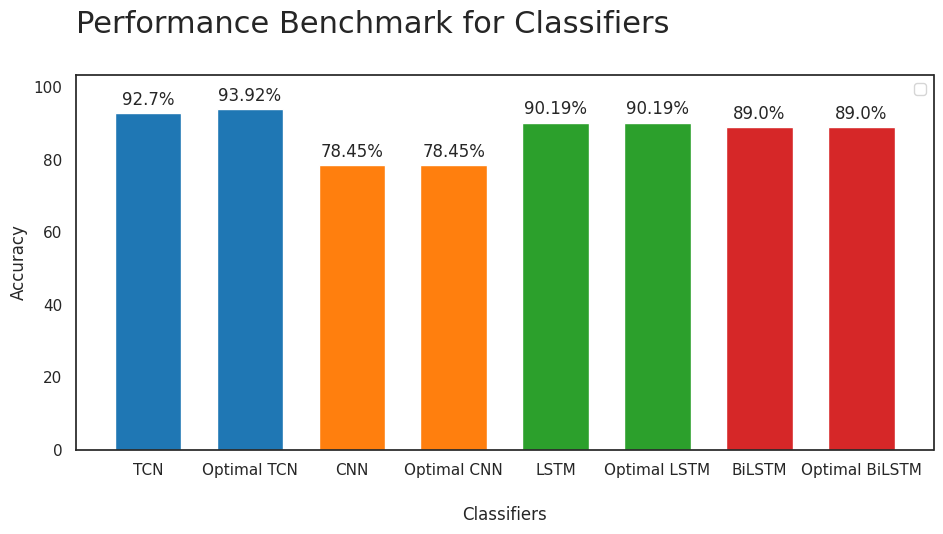

In [91]:
metrics = [
    r(tcn_train_metric['accuracy']), 
    r(loaded_tcn_train_metric['accuracy']), 
    r(cnn_train_metric['accuracy']), 
    r(loaded_cnn_train_metric['accuracy']), 
    r(lstm_train_metric['accuracy']), 
    r(loaded_lstm_train_metric['accuracy']), 
    r(bilstm_train_metric['accuracy']), 
    r(loaded_bilstm_train_metric['accuracy'])]

classifier = ['TCN', 'Optimal TCN', 'CNN', 'Optimal CNN', 'LSTM', 'Optimal LSTM', 'BiLSTM', 'Optimal BiLSTM']
fig, ax = plt.subplots(1, figsize=(9.5,5.5))

unique_colors = [color_pal[i // 2] for i in range(len(classifier))]
bars = ax.bar(classifier, metrics, color=unique_colors, width=.65)
ax.set_title('Performance Benchmark for Classifiers\n', loc='left', fontsize=22)
plt.xlabel('Classifiers', fontsize=12, labelpad=20)
plt.ylabel('Accuracy', fontsize=12)
ax.bar_label(bars, labels=[f"{metric}%" for metric in metrics], padding=3)
plt.tight_layout()
plt.margins(x=0.05, y=0.1)
plt.legend()
plt.show()

In [89]:
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, roc_auc_score, auc, precision_recall_curve, average_precision_score, f1_score, recall_score, precision_score

with tpu_strategy.scope():
    # Make predictions on the test set
    tcn_y_prob = loaded_tcn_model.predict(reshaped_X_test, batch_size=65536 * tpu_strategy.num_replicas_in_sync)
    # Convert the output into a more readable format, if needed
    tcn_y_pred = np.argmax(tcn_y_prob, axis=1)

# True Labels
y_true = y_test

print(f"Prediction Shape: {np.array(tcn_y_pred).shape}")

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(y_true, tcn_y_pred)
print("Confusion Matrix:")

value_counts = dataset['Label'].value_counts()

# Extract the indices as a list
indices_list = value_counts.index.tolist()

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.DataFrame(np.squeeze(conf_matrix), columns=[indices_list], index=[indices_list])

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step
Prediction Shape: (2750275,)
Confusion Matrix:


,Benign,DDoS-LOIC-HTTP,DoS-Hulk,DDoS-HOIC,Botnet,DDoS,DDoS-NTP,DDoS-TFTP,Bruteforce-SSH,Infiltration,DoS-Goldeneye,DDoS-Syn,DDoS-UDP,DoS-Slowloris,DDoS-MSSQL,DDoS-UDPLag,Bruteforce-FTP,DoS-Slowhttptest,DDoS-Ddossim,DDoS-DNS,DoS-Slowread,Portscan,DDoS-LDAP,Webattack-bruteforce,DDoS-SNMP,DDoS-Slowloris,DoS-Slowheaders,Webattack-XSS,DoS-Rudy,DDoS-NetBIOS,DoS-Slowbody,Webattack-SQLi,DoS-Heartbleed
Benign,2128291,337,1,48,70,16,0,421,135,12186,58,51,4,34,52,49,47,48,40,904,0,12958,1,0,1,0,37,0,66,0,0,1,1
DDoS-LOIC-HTTP,1127,42455,0,0,2,0,0,4,0,6,0,2,0,2,0,1,0,0,1,68,0,119,1,0,1,0,0,0,0,1,0,0,0
DoS-Hulk,1788,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0
DDoS-HOIC,154,0,0,28994,0,0,0,0,0,11,0,0,0,0,0,0,16,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0
Botnet,10466,0,0,0,24417,0,0,5,0,142,0,1,0,0,0,27,1,0,0,3,0,3357,0,0,0,0,0,0,0,0,0,0,0
DDoS,163,0,0,0,0,238,0,0,257,0,228,22,0,111,0,0,17,57,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0
DDoS-NTP,628,11,0,0,1,0,0,0,0,565,0,0,0,0,0,0,0,0,0,327,0,3,0,0,0,0,0,0,0,0,0,0,0
DDoS-TFTP,8513,1,0,1,2,0,0,48353,0,103,4,3,1,0,0,0,14,0,0,12,0,2651,0,0,0,0,0,0,0,0,0,0,0
Bruteforce-SSH,7,0,0,0,0,208,0,0,252,0,62,1,0,94,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Infiltration,8652,3,0,0,41,0,0,15,0,163391,2,1,0,0,2,12,32,1,0,1,0,456,0,0,0,0,0,0,0,0,0,0,0


In [90]:
# Calculate F1-score, recall, precision, and AUC
tcn_f1 = round(f1_score(y_true, tcn_y_pred, average="micro") * 100, 2)
tcn_recall = round(recall_score(y_true, tcn_y_pred, average="micro") * 100, 2)
tcn_precision = round(precision_score(y_true, tcn_y_pred, average="micro") * 100, 2)
print(f"TCN F1-score: {tcn_f1} %")
print(f"TCN Recall: {tcn_recall} %")
print(f"TCN Precision: {tcn_precision} %")

roc_auc_micro = round(roc_auc_score(y_test, tcn_y_prob, multi_class='ovr', average='micro')* 100, 2)
roc_auc_macro = round(roc_auc_score(y_test, tcn_y_prob, multi_class='ovr', average='macro')* 100, 2)
print(f"TCN Micro-average AUC: {roc_auc_micro} %")
print(f"TCN Macro-average AUC: {roc_auc_macro} %")

# Print classification report for detailed metrics
print("Classification Report:")
print(classification_report(y_true, tcn_y_pred))

TCN F1-score: 93.85 %
TCN Recall: 93.85 %
TCN Precision: 93.85 %
TCN Micro-average AUC: 99.83 %
TCN Macro-average AUC: 91.59 %
Classification Report:


/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.95      0.99      0.97   2155857
           1       0.99      0.97      0.98     43790
           2       0.00      0.00      0.00      1795
           3       1.00      0.99      1.00     29178
           4       0.99      0.64      0.77     38419
           5       0.35      0.22      0.27      1100
           6       0.00      0.00      0.00      1535
           7       0.95      0.81      0.87     59658
           8       0.29      0.40      0.34       628
           9       0.87      0.95      0.90    172609
          10       0.82      0.91      0.86      3535
          11       0.99      0.99      0.99     36398
          12       0.00      0.00      0.00       203
          13       0.33      0.24      0.28       605
          14       0.00      0.00      0.00       557
          15       0.62      0.01      0.02     14327
          16       0.99      0.99      0.99     29650
          17       0.89    

/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
